# Create Environment

In [16]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=100

global T
global target
global theta_0
T=8.5
target=3.88
theta_0=-0.11318
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

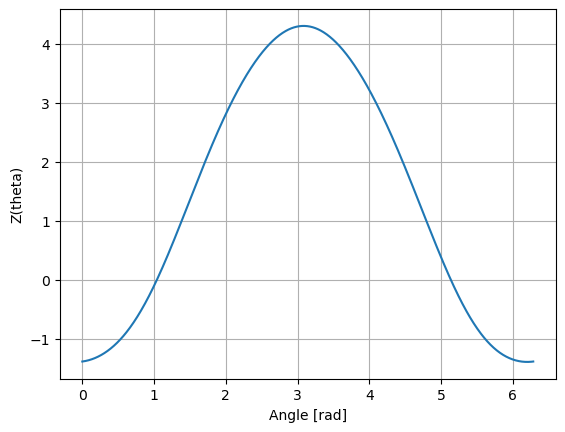

In [17]:
def Z(theta):
    return 1.417-2.9006*np.cos(theta)+0.0217*np.cos(2*theta)+0.0603*np.cos(3*theta)+0.02148*np.cos(4*theta)+0.1624*np.sin(theta)
    +0.4248*np.sin(theta)+0.0553*np.sin(3*theta)-0.0126*np.sin(4*theta)

#check the correctness of Z
x = np.linspace(0, 2*np.pi, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()

In [18]:
def next_step_and_reward(theta_k,u_k):
    theta_new=theta_k+delta_t*(w+Z(theta_k)*u_k)
    while theta_new>1.5*np.pi:
        theta_new-=2*np.pi
    while theta_new<-0.5*np.pi:
        theta_new+=2*np.pi
    return theta_new, -(theta_new-target)**2
    #return theta_new, -0.5*(theta_new-target)**2+abs(theta-target)-abs(theta_new-target)

def reward(theta_k):
    return -(theta_k-target)**2



# Learning Settings

In [19]:
global lr
lr=0.01
global eps
eps=0.1
global max_u
max_u=1
global precision
precision=0.0002
def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    ind=np.argmax(cand)
    possible=np.linspace(0, max_u, int(max_u/precision+1))
    return possible[ind]
    
def decide_u(theta,cand,init=False):
    explo=exploration()
    if init or explo:
        possible=np.linspace(0, max_u,  int(max_u/precision+1))
        return(possible[np.random.randint( int(max_u/precision+1))])
    else:
        return(find_max(cand))
    
def generate_cand(theta):
    possible=np.linspace(0, max_u,  int(max_u/precision+1))
    cand=[]
    for i in range( int(max_u/precision+1)):
        cand.append([theta,possible[i]])
    return np.array(cand)

history_su=np.array([[]])
history_r=np.array([])
possible_u=np.linspace(0, max_u,  int(max_u/precision+1))

# Simulation


In [20]:
num_iter=100

theta_result=[]
for iterr in tqdm(range(num_iter)):
    #initialize
    theta=theta_0
    u_t=[]
    theta_t=[theta_0]
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            u_k = decide_u(theta,candidates_u,init=True)
            theta_new, r = next_step_and_reward(theta,u_k)
            if time==0:
                history_su = np.array([theta,u_k]).reshape(1,-1)
            else:
                history_su = np.concatenate((history_su, np.array([theta,u_k]).reshape(1,-1)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta=theta_new
            u_t.append(u_k)
        elif iterr>10:  
            eps=0
            x_cand = generate_cand(theta)
            candidates_u, std_u = gpr.predict(x_cand.reshape(-1,2), return_std=True)
            u_k = decide_u(theta,candidates_u)
            theta_new, r = next_step_and_reward(theta,u_k)
            history_su = np.concatenate((history_su, np.array([theta,u_k]).reshape(-1,2)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta = theta_new
            u_t.append(u_k)
            theta_t.append(theta)
        else:            
            x_cand = generate_cand(theta)
            candidates_u, std_u = gpr.predict(x_cand.reshape(-1,2), return_std=True)
            u_k = decide_u(theta,candidates_u)
            theta_new, r = next_step_and_reward(theta,u_k)
            history_su = np.concatenate((history_su, np.array([theta,u_k]).reshape(-1,2)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta = theta_new
            u_t.append(u_k)
            theta_t.append(theta)
    gpr = GaussianProcessRegressor(alpha=1e-8).fit(history_su, history_r.reshape(-1,1))
    print("theta =",theta)
    theta_result.append(theta)
    if abs(r)<1e-4:
        break
    #print(history_su.shape)
    print(u_t)
    print(theta_t)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

theta = -0.9638080659422074
[0.9598000000000001, 0.0852, 0.7858, 0.9492, 0.28700000000000003, 0.1134, 0.2366, 0.4746, 0.7042, 0.5502, 0.8378, 0.4818, 0.3326, 0.752, 0.8774000000000001, 0.3168, 0.11760000000000001, 0.9304, 0.5838, 0.12560000000000002, 0.30560000000000004, 0.505, 0.0118, 0.0512, 0.1826, 0.3544, 0.3206, 0.0534, 0.8460000000000001, 0.9982000000000001, 0.61, 0.1986, 0.1282, 0.7596, 0.3642, 0.5806, 0.7962, 0.46900000000000003, 0.2006, 0.48300000000000004, 0.7368, 0.7504000000000001, 0.9868, 0.7758, 0.7296, 0.098, 0.262, 0.8266, 0.1408, 0.8536, 0.6064, 0.8852000000000001, 0.9730000000000001, 0.49060000000000004, 0.663, 0.4428, 0.606, 0.1114, 0.7474000000000001, 0.7160000000000001, 0.675, 0.8946000000000001, 0.41000000000000003, 0.9928, 0.4184, 0.7100000000000001, 0.26, 0.3856, 0.8330000000000001, 0.1456, 0.4302, 0.5348, 0.496, 0.5048, 0.7974, 0.8534, 0.7954, 0.0108, 0.8252, 0.4872, 0.0466, 0.7206, 0.874, 0.6362, 0.4984, 0.1024, 0.8858, 0.9744, 0.0816, 0.6126, 0.929, 0.406, 0.

  2%|█▋                                                                                | 2/100 [00:02<01:42,  1.05s/it]

theta = -1.086866015342439
[0.0, 0.0, 0.0, 0.33680000000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1476, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33140000000000003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5356000000000001, 0.559, 0.5736, 0.5818, 0.5848, 0.8108000000000001, 0.5776, 0.5704, 0.5616, 0.5522, 0.5422, 0.5324, 0.523, 0.514, 0.5058, 0.4984, 0.49160000000000004, 0.4854, 0.4802, 0.6126, 0.47040000000000004, 0.46680000000000005, 1.0, 0.5728, 1.0, 1.0, 1.0, 1.0, 0.5916, 0.0872, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.06270602267246485, -0.040171391823930466, -0.01763676097539608, 0.004897869873138304, 0.02743250072167269, 0.049967131570207074, 0.07250176241874146, 0.09503639326727584, 0.11757102411581022, 0.1401056549643446, 0.

  3%|██▍                                                                               | 3/100 [00:05<03:33,  2.20s/it]

theta = -0.08906613017020992
[0.0, 0.0, 0.0886, 0.0, 0.7230000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.3632, 0.5664, 0.0, 0.0, 0.0, 0.0, 0.0886, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.268, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.37, 0.0, 0.0848, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.1782, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.7254, 0.0, 0.0, 0.0, 0.4556, 0.8758, 0.5258, 0.0, 0.0, 0.9918, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.05601930682103364, -0.03348467597249925, -0.09603301469574861, -0.07349838384721423, -0.05096375299867985, -0.028429122150145463, -0.005894491301611078, 0.016640139546923307, 0.03917477039545769, 0.061709401243992074, -0.031902532827176935, -0.0521045956187495, -0.09629558408600014, -0.07376095323746576, -0.05122632238893138, -0.028691691540396993, -0.00

  4%|███▎                                                                              | 4/100 [00:12<05:57,  3.72s/it]

theta = 0.23805675711328422
[0.0, 0.0, 0.0, 0.0, 0.0, 0.219, 0.0, 0.046200000000000005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014, 0.9926, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.128, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.26280000000000003, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0526, 1.0, 0.0, 0.0, 0.0, 1.0, 0.8094, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, -0.003664676333457042, 0.018869954515077343, 0.035998235349891064, 0.058532866198425446, 0.08106749704695983, 0.10360212789549421, 0.1261367587440286, 0.14867138959256299, 0.17120602044109737, 0.19374065128963175, 0.21627528213816613, 0.2388099129867005, 0.259814541373222, 0.17503655467676904, 

  5%|████                                                                              | 5/100 [00:20<08:39,  5.47s/it]

theta = 0.46433925597620257
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.997, 0.0, 0.0, 0.0, 0.36560000000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9156000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9262, 0.0, 0.0, 0.9242, 0.0, 0.0, 0.0, 0.925, 0.0, 0.0, 0.0, 0.9256000000000001, 0.0, 0.0, 0.0, 0.9264, 0.0, 0.0, 0.9244, 0.7138, 0.0, 0.3242, 0.0, 0.1192, 0.0, 0.0, 0.0, 0.9252, 0.0, 0.5008, 0.6256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9264, 0.0, 0.917, 0.0, 0.6004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9262, 0.0, 0.0, 0.924, 0.0, 0.0, 0.0, 0.9248000000000001, 0.0, 0.0, 0.0, 0.9256000000000001, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.17977020103094699, 0.09047506533215927, 0.11300969618069365, 0.13554

  6%|████▉                                                                             | 6/100 [00:32<11:57,  7.63s/it]

theta = 0.658957900392188
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6990000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33740000000000003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3796, 0.14200000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6228, 0.0, 0.6222, 0.794, 0.0, 0.0, 0.5214, 0.0, 0.6214000000000001, 0.6242, 0.6646000000000001, 0.0, 0.0, 0.6242, 0.0, 0.6238, 0.0, 0.6234000000000001, 0.0, 0.623, 0.0, 0.6224000000000001, 0.0, 0.6218, 0.0, 0.621, 0.624, 0.0, 0.6236, 0.0, 0.6232, 0.0, 0.6226, 0.0, 0.622, 0.0, 0.6214000000000001, 0.6242, 0.0, 0.624, 0.0, 0.6234000000000001, 0.0, 0.623, 0.0, 0.6226, 0.0, 0.6218, 0.0, 0.0776, 0.6176, 0.621, 0.624, 0.0, 0.6236, 0.0, 0.623, 0.0, 0.6224000000000001]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387

  7%|█████▋                                                                            | 7/100 [00:51<17:07, 11.04s/it]

theta = 3.8216545320807063
[0.0, 0.0, 0.0898, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43260000000000004, 0.0, 0.0, 0.0, 0.0, 0.0396, 0.0, 0.0, 0.0, 0.0, 0.4314, 0.4338, 0.436, 0.4378, 0.4394, 0.4408, 0.4418, 0.4428, 0.4436, 0.46180000000000004, 0.4444, 0.4446, 0.4446, 0.4444, 0.444, 0.4434, 0.8016000000000001, 0.4418, 0.062, 0.43960000000000005, 0.8836, 0.43720000000000003, 0.4364, 0.4358, 0.4358, 0.999, 0.44, 0.4446, 0.452, 0.46340000000000003, 0.4806, 0.7212000000000001, 0.558, 0.6236, 0.6454000000000001, 0.8772000000000001, 1.0, 0.0, 0.0, 0.541, 0.0, 0.0, 0.0, 0.0, 0.10400000000000001, 0.0, 0.0, 0.0, 0.6072000000000001, 0.0, 0.0, 0.8374, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.056160749701845876, -0.03362611885331149, -0.011091488004777102, 0.011443142843757283, 0.03397777369229167, 0.05651240454082605, 0.07904703538936043, 0

  8%|██████▌                                                                           | 8/100 [01:11<21:19, 13.91s/it]

theta = 4.633195717520007
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.729, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.124, 0.0772, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9588000000000001, 0.0, 0.028200000000000003, 0.0, 0.0, 0.0, 0.008400000000000001, 0.7702, 0.0304, 0.6990000000000001, 0.7034, 0.7086, 0.7144, 0.7218, 0.731, 0.7432000000000001, 0.7604000000000001, 0.7872, 0.8354, 0.9742000000000001, 1.0, 1.0, 1.0, 0.1784, 0.1782, 0.17800000000000002, 0.1776, 0.1328, 0.1764, 0.1756, 0.5548000000000001, 0.1708, 0.16840000000000002, 0.1656, 0.9912000000000001, 0.13440000000000002, 0.9714, 0.7146, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216

  9%|███████▍                                                                          | 9/100 [01:35<26:04, 17.19s/it]

theta = 2.4205573067875963
[0.0, 0.24200000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9642000000000001, 0.4964, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041, 0.0658, 0.0826, 0.13240000000000002, 0.1058, 0.11560000000000001, 0.1246, 0.1328, 0.1404, 0.1476, 0.15460000000000002, 0.1612, 0.1678, 0.17420000000000002, 0.1806, 0.187, 0.19340000000000002, 0.1998, 0.2066, 0.2134, 0.22060000000000002, 0.22840000000000002, 0.2368, 0.2462, 0.25720000000000004, 0.2706, 0.379, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.7608, 0.0, 0.0, 0.0, 0.0, 0.10300000000000001, 0.0, 0.0368, 0.0, 0.0, 0.0, 0.0, 0.4984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.09663886667026214, -0.07410423582172776, -0.05156960497319338, -0.029034974124658993, -0.006500343276124608, 0.016034287572409777, 0.03856891842094416, 0.061103549269478544, 0.08363818011801

 10%|████████                                                                         | 10/100 [02:03<30:43, 20.48s/it]

theta = -0.9024629379317141
[0.0378, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8424, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4122, 0.0, 0.0, 0.0, 0.0004, 0.0026000000000000003, 0.005, 0.008, 0.0118, 0.0162, 0.0216, 0.9764, 0.9822000000000001, 0.9884000000000001, 0.9944000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6876, 0.636, 0.22640000000000002, 0.2036, 0.2026, 0.20800000000000002, 0.2174, 1.0, 1.0, 0.096, 0.049600000000000005, 0.8288000000000001, 0.8242, 0.811, 0.791, 0.7652, 0.7346, 0.6998000000000001, 0.6596000000000001, 0.6108, 0.029, 0.0206, 0.0146, 0.009600000000000001, 0.0046, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09509879026115398, -0.0725641594126196, -0.05002952856408521, -0.027494897715550828, -0.004960266867016443, 0.017574363981517942, 0.04010899483005233, 0.06264362567858671, 0.08517825652712109, 0.107712887

 11%|████████▉                                                                        | 11/100 [02:36<35:53, 24.20s/it]

theta = -0.8776741681619822
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6228, 0.0, 0.0, 0.0, 0.5222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0048000000000000004, 0.011000000000000001, 0.017400000000000002, 0.024, 0.030600000000000002, 0.0376, 0.0446, 0.0522, 0.060000000000000005, 0.0684, 0.8736, 0.929, 0.9852000000000001, 1.0, 0.5442, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4534, 1.0, 0.8914000000000001, 0.503, 1.0, 0.8674000000000001, 0.8506, 0.869, 0.2252, 0.21580000000000002, 0.20720000000000002, 0.19920000000000002, 0.1918, 0.18460000000000001, 0.1778, 1.0, 0.621, 0.9858, 0.9538000000000001, 0.9296000000000001, 0.9092, 0.8908, 0.26780000000000004, 0.24200000000000002, 0.215, 0.184, 0.026600000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1032]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.02

 12%|█████████▋                                                                       | 12/100 [03:12<40:57, 27.92s/it]

theta = -0.9041283442703472
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0086, 0.021, 0.033, 0.0446, 0.0562, 0.0674, 0.6798000000000001, 0.6858000000000001, 0.6906, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7554000000000001, 0.8788, 0.9560000000000001, 0.9188000000000001, 0.8936000000000001, 0.9024000000000001, 0.08800000000000001, 0.0906, 0.0926, 0.094, 0.6452, 0.6456000000000001, 0.6144000000000001, 0.0906, 0.08940000000000001, 0.0884, 0.08700000000000001, 0.0854, 0.0838, 0.2518, 0.2766, 0.3078, 1.0, 1.0, 0.9864, 0.9086000000000001, 0.8642000000000001, 0.8288000000000001, 0.7966000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 

 13%|██████████▌                                                                      | 13/100 [03:54<46:25, 32.02s/it]

theta = -0.8009952336621031
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0206, 0.8358, 0.8654000000000001, 0.9056000000000001, 0.9604, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7704000000000001, 1.0, 1.0, 0.6696000000000001, 0.7496, 0.908, 0.38320000000000004, 0.381, 0.431, 1.0, 0.3754, 0.1968, 0.1342, 0.11040000000000001, 0.096, 0.0852, 0.5134000000000001, 1.0, 1.0, 1.0, 0.9926, 0.9258000000000001, 0.8672000000000001, 0.8096, 0.2194, 0.13040000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.

 14%|███████████▎                                                                     | 14/100 [04:41<52:39, 36.74s/it]

theta = -0.7240297988750162
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0184, 0.038400000000000004, 0.6296, 0.5932000000000001, 0.5722, 0.9428000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7842, 0.8118000000000001, 1.0, 1.0, 0.653, 0.8728, 0.9212, 0.439, 1.0, 1.0, 0.099, 0.097, 0.0952, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7458, 0.2642, 0.18580000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.17977020103094699, 0.20230483187948137, 0.22483946272801575, 0.24737409357655013,

 15%|████████████▏                                                                    | 15/100 [05:35<59:07, 41.74s/it]

theta = -0.7908401206896416
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0032, 0.032600000000000004, 0.060200000000000004, 0.747, 0.7444000000000001, 0.6728000000000001, 0.9214, 1.0, 1.0, 1.0, 1.0, 1.0, 0.774, 0.8428, 1.0, 1.0, 0.7918000000000001, 0.8942, 0.4176, 0.4218, 1.0, 0.622, 0.1046, 0.10160000000000001, 0.09920000000000001, 0.09720000000000001, 0.0954, 0.09380000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.28140000000000004, 0.1996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.17

 16%|████████████▋                                                                  | 16/100 [06:36<1:06:28, 47.48s/it]

theta = -0.769046307453382
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0328, 0.7130000000000001, 0.6864, 0.6522, 0.6324000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8462000000000001, 1.0, 1.0, 0.6808000000000001, 0.8702000000000001, 0.9248000000000001, 0.4796, 1.0, 0.4708, 0.11120000000000001, 0.10540000000000001, 0.1014, 0.0984, 0.09580000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7742, 0.6922, 0.21080000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.17977020103094

 17%|█████████████▍                                                                 | 17/100 [07:43<1:13:46, 53.33s/it]

theta = -0.9729896657646815
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012400000000000001, 0.092, 0.7124, 0.681, 0.6546000000000001, 0.6484, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8078000000000001, 1.0, 1.0, 0.5366000000000001, 0.7488, 0.883, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4238, 1.0, 0.6064, 0.1136, 0.108, 0.1044, 0.1018, 0.0998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7258, 0.2232, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.17977020103094699, 0.20230483187948137, 0.22483946272801575, 0.24737409357655013, 0.2699087

 18%|██████████████▏                                                                | 18/100 [08:57<1:21:22, 59.54s/it]

theta = -0.7922085365097336
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083, 0.758, 0.6104, 0.5840000000000001, 0.935, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8764000000000001, 1.0, 1.0, 0.6006, 0.8144, 0.8978, 0.3506, 0.45020000000000004, 1.0, 0.5146000000000001, 0.11040000000000001, 0.10640000000000001, 0.1046, 0.10360000000000001, 0.10300000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.741, 0.22460000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.17977020103094699, 0.202304

 19%|███████████████                                                                | 19/100 [10:18<1:29:16, 66.13s/it]

theta = -0.7710683192759504
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1192, 0.7544000000000001, 0.7084, 0.6264000000000001, 0.613, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8726, 0.9938, 1.0, 0.5674, 0.7536, 0.8784000000000001, 0.3168, 0.37460000000000004, 1.0, 1.0, 0.1102, 0.10740000000000001, 0.1062, 0.1056, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7752, 0.23340000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11318, -0.09064536915146562, -0.06811073830293124, -0.04557610745439686, -0.023041476605862473, -0.000506845757328088, 0.022027785091206297, 0.04456241593974068, 0.06709704678827506, 0.08963167763680945, 0.11216630848534383, 0.13470093933387822, 0.1572355701824126, 0.17977020103094699, 0.20230483187948137, 0.22483946272801575, 0.247

 19%|███████████████▍                                                                 | 19/100 [11:10<47:39, 35.30s/it]


KeyboardInterrupt: 

# Results

In [ ]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

In [ ]:
x = np.linspace(0, T, N+2)
plt.plot(x, theta_t, color='m')
plt.xlabel('t')
plt.ylabel('theta(t)')
plt.title("theta(t) vs time")
plt.grid()
plt.show()

In [ ]:
num_iter=len(theta_result)

x = np.linspace(1, num_iter, num_iter)
plt.plot(x, theta_result)
plt.xlabel('iteration')
plt.ylabel('theta(T)')
plt.title("theta(T) vs iterations")
plt.grid()
plt.show()